## Import Libraries

In [2]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split

# Colab auth
from google.colab import auth
from google.cloud import storage

## Define download function, and download tf-records

In [3]:
def download_TFRecords(gcp_dir,
                       local_dir,
                       secrets_json,
                       bucket_name):
    print("downloading")

    # Clear
    #shutil.rmtree(input_images, ignore_errors=True, onerror=None)
    #makedirs()
    start_time = time.time()

    client = storage.Client.from_service_account_json(secrets_json)
    bucket = client.get_bucket(bucket_name)

    blobs = bucket.list_blobs(prefix=gcp_dir + "/")

    for blob in blobs:
        if not blob.name.endswith("/"):
            filename = str(blob.name)
            filename = filename.replace(gcp_dir,"")
            destination_path = local_dir + filename
            blob.download_to_filename(destination_path)

    execution_time = (time.time() - start_time)/60.0

    print("finished downloading")
    print("Execution time (mins)",execution_time)

In [4]:
# Before downloading you must create destination directory to store the tf-records
tfrecords_output_dir = "tf-records"
if os.path.exists(tfrecords_output_dir):
  shutil.rmtree(tfrecords_output_dir)
tf.io.gfile.makedirs(tfrecords_output_dir)

Before running this cell, create a folder called secrets and put the secrets json in it. If running in collab, you'll automatically be running out of the content folder.

In [6]:
# Define these variables before running function
gcp_dir = 'tf-records'
local_dir = '/content/tf-records'
secrets_json = '/content/secrets/gcp-rehab-ai-secret.json'
bucket_name = "rehab-image-detection-data"

# Download TF records
download_TFRecords(gcp_dir=gcp_dir,
                   local_dir=local_dir,
                   secrets_json=secrets_json,
                   bucket_name=bucket_name)

downloading
finished downloading
Execution time (mins) 0.824301548798879


## Define helper functions

In [ ]:
## this function parses each photo and defines the size of the image and the label
## It is used in the create_dataset() function

# @tf.function
def parse_tfrecord_example(example_proto):

  # Read TF Records
  feature_description = {
      'image': tf.io.FixedLenFeature([], tf.string),
      'label': tf.io.FixedLenFeature([], tf.int64)
  }

  parsed_example = tf.io.parse_single_example(example_proto, feature_description)

  # Image
  # image = tf.image.decode_jpeg(parsed_example['image'])
  image = tf.io.decode_raw(parsed_example['image'], tf.uint8)
  image.set_shape([num_channels * image_height * image_width])
  image = tf.reshape(image, [image_height, image_width, num_channels])
  # Label
  label = tf.cast(parsed_example['label'], tf.int32)
  label = tf.one_hot(label, num_classes)

  return image, label

In [ ]:
## this function normalizes the pixels in the image
## it is used in the create_dataset() function

# Normalize pixels
def normalize(image, label):
  image = image/255
  return image, label

In [ ]:
# This function creates the tf-records prefetch object
# you can specify which tf-records to pull from, thus creating your train, val, test sets

def create_dataset(batch_size,
                   num_channels,
                   image_height,
                   image_width,
                   num_classes,
                   records_dir,
                   prefix):

  # Read the tfrecord files
  tfrecord_files = tf.data.Dataset.list_files(records_dir + prefix)

  #############
  # Train data
  #############
  data = tfrecord_files.flat_map(tf.data.TFRecordDataset)
  data = data.map(parse_tfrecord_example, num_parallel_calls=tf.data.AUTOTUNE)
  data = data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
  data = data.batch(batch_size)
  data = data.prefetch(buffer_size=tf.data.AUTOTUNE)

  return data


## Create Train, Val and Test Datasets from TFRecords

- use create_dataset() function to create the TFrecords prefetch objects
- the prefectch object will then be fed into model.fit() for training

In [ ]:
# Create train_data

# Define these variables and directories before running function
batch_size = 128
num_channels = 3
image_height = 224
image_width = 224
num_classes = 2
# directory where the tf-records are pulling from
records_dir = '/content/tf-records'
# Defines which tfrecords to pull. Change to '/train*' to get all train tf-records
prefix = '/train_0000.tfrecords'

# Create train_data set
train_data = create_dataset(batch_size=batch_size,
                   num_channels=num_channels,
                   image_height=image_height,
                   image_width=image_width,
                   num_classes=num_classes,
                   records_dir=records_dir,
                   prefix=prefix)
print(train_data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


In [ ]:
# Create val_data

# Define these variables and directories before running function
batch_size = 128
num_channels = 3
image_height = 224
image_width = 224
num_classes = 2
# where the tf-records are pulling from
records_dir = '/content/tf-records'
# Defines which tfrecords to pull. Change prefix to '/val*' to get all val tf-records
prefix = '/val_0000.tfrecords'

# Create val_data set
val_data = create_dataset(batch_size=batch_size,
                   num_channels=num_channels,
                   image_height=image_height,
                   image_width=image_width,
                   num_classes=num_classes,
                   records_dir=records_dir,
                   prefix=prefix)
print(val_data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


In [ ]:
# Create test_data

# Define these variables and directories before running function
batch_size = 128
num_channels = 3
image_height = 224
image_width = 224
num_classes = 2
# where the tf-records are pulling from
records_dir = '/content/tf-records'
# Defines which tfrecords to pull. Change to '/test*' to get all test tf-records
prefix = '/test_0000.tfrecords'

# Create test_data set
test_data = create_dataset(batch_size=batch_size,
                   num_channels=num_channels,
                   image_height=image_height,
                   image_width=image_width,
                   num_classes=num_classes,
                   records_dir=records_dir,
                   prefix=prefix)
print(test_data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


## Build Toy Model

In [ ]:
# Build Model
def build_simple_cnn_model(image_height, image_width, num_channels, num_classes):
  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels
  model_input = keras.Input(shape=input_shape)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(model_input)
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Flatten
  hidden = keras.layers.Flatten()(hidden)

  #  Hidden Layer, Classification Block
  hidden = keras.layers.Dense(units=64, activation='relu')(hidden)
  hidden = keras.layers.Dense(units=64, activation='relu')(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(model_input, output, name='simple_cnn_model')

  return model

In [ ]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 5

# Free up memory
K.clear_session()

# Build the model
model = build_simple_cnn_model(image_height, image_width, num_channels, num_classes)

# Print the model architecture
print(model.summary())

Model: "simple_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                  

## Train on tf-records datasets

- Pass in the tf-records datasets in the model.fit function

In [ ]:
# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum = 0.001)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Epoch 1/5
23/23 [==============================] - 63s 2s/step - loss: 0.6484 - accuracy: 0.6052 - val_loss: 0.6410 - val_accuracy: 0.6241
Epoch 2/5
23/23 [==============================] - 26s 1s/step - loss: 0.6391 - accuracy: 0.6163 - val_loss: 0.6326 - val_accuracy: 0.6247
Epoch 3/5
23/23 [==============================] - 24s 1s/step - loss: 0.6290 - accuracy: 0.6226 - val_loss: 0.6210 - val_accuracy: 0.6369
Epoch 4/5
23/23 [==============================] - 24s 1s/step - loss: 0.6230 - accuracy: 0.6458 - val_loss: 0.6117 - val_accuracy: 0.6641
Epoch 5/5
23/23 [==============================] - 26s 1s/step - loss: 0.6111 - accuracy: 0.6656 - val_loss: 0.6279 - val_accuracy: 0.6580
Training execution time (mins) 3.0725043257077536


In [ ]:
def evaluate_model(model,test_data, training_results):

  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()

  # Evaluate on test data
  if type(test_data) is tuple:
    evaluation_results = model.evaluate(test_data[0],test_data[1])
  else:
    evaluation_results = model.evaluate(test_data)
  print(evaluation_results)

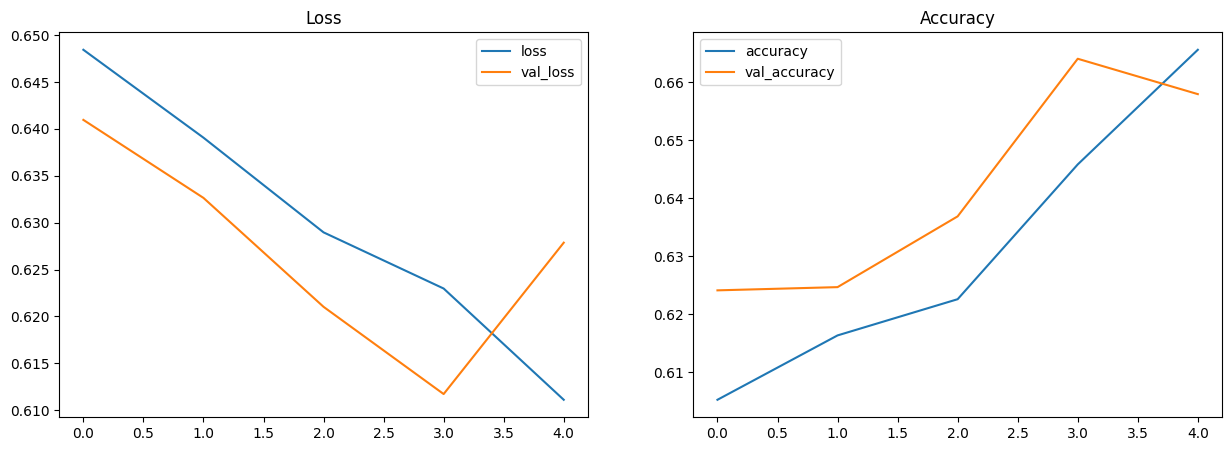

18/18 [==============================] - 9s 481ms/step - loss: 0.6126 - accuracy: 0.6824
[0.6125857830047607, 0.6823633909225464]


In [ ]:
# Graphs are showing training and validation loss and accuracy from the training history
# Two numbers printed at the end are showing loss and accuracy when evaluated on test_data

evaluate_model(model, test_data, training_results)